# 1. Import the required packages

In [2]:
import os
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# 2. Download the dataset

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Set kaggle config directory if needed
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

api = KaggleApi()
api.authenticate()

# This will download the ZIP file
print("⏬ Starting download...")
api.dataset_download_files(
    'meowmeowmeowmeowmeow/gtsrb-german-traffic-sign',
    path='GTSRB',
    unzip=False  # we'll unzip later
)

print("✅ Download complete!")

# Optional: check file size
file_path = os.path.join('GTSRB', 'gtsrb-german-traffic-sign.zip')
if os.path.exists(file_path):
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"📦 File size: {size_mb:.2f} MB")

    # unzip
    import zipfile
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        print("📂 Unzipping...")
        zip_ref.extractall('GTSRB')
        print("✅ Unzipping complete.")
else:
    print("❌ File not found after download.")


⏬ Starting download...
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


HTTPError: 403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/download/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?raw=false

# 3. Locating and cropping

In [3]:
class GTSRBCustomDataset(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row["Path"])
        image = Image.open(img_path).convert("RGB")

        # Crop the region of interest (ROI)
        x1, y1, x2, y2 = row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]
        image = image.crop((x1, y1, x2, y2))

        if self.transform:
            image = self.transform(image)

        label = int(row["ClassId"])
        return image, label


# 4. Resizing, normalizing, and loading the dataset

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load full train dataset
full_train_dataset = GTSRBCustomDataset(
    csv_path="./GTSRB/Train.csv",
    root_dir="./GTSRB",  # root for relative Path column
    transform=transform
)

# Split into train and validation
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Load test dataset
test_dataset = GTSRBCustomDataset(
    csv_path="./GTSRB/Test.csv",
    root_dir="./GTSRB",
    transform=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# 5. Defining the CNN model

In [5]:
# Example CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model, loss, optimizer

In [6]:
model = SimpleCNN(num_classes=43)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda


# 4. Training

In [7]:
# Training function with tqdm
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        tqdm_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, labels in tqdm_train:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accuracy and loss
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            tqdm_train.set_postfix({
                'Loss': f'{running_loss / total:.4f}',
                'Acc': f'{100. * correct / total:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        print(f"[{epoch+1}] Train Acc: {100. * correct / total:.2f}%, Val Acc: {100. * val_correct / val_total:.2f}%")

# Example usage
train_model(model, train_loader, val_loader, epochs=5)

[1] Train Acc: 64.13%, Val Acc: 95.03%


[2] Train Acc: 92.64%, Val Acc: 97.16%


[3] Train Acc: 95.83%, Val Acc: 98.47%


[4] Train Acc: 97.21%, Val Acc: 98.80%


[5] Train Acc: 97.71%, Val Acc: 98.83%


In [8]:
def plot_custom_colored_confusion_matrix(y_true, y_pred, class_names=None, figsize=(15, 12)):
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]

    # Normalize by row (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Custom colormap: one unique color per class
    colors = plt.cm.get_cmap('tab20', n_classes)

    fig, ax = plt.subplots(figsize=figsize)

    for i in range(n_classes):
        for j in range(n_classes):
            color = colors(i)
            value = cm[i, j]
            ax.text(j, i, f"{value}", ha='center', va='center',
                    color='white' if cm_normalized[i, j] > 0.5 else 'black',
                    fontsize=8, bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))

    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    if class_names is not None:
        ax.set_xticklabels(class_names, rotation=90, fontsize=10)
        ax.set_yticklabels(class_names, fontsize=10)
    else:
        ax.set_xticklabels(range(n_classes), rotation=90)
        ax.set_yticklabels(range(n_classes))

    ax.set_title("Confusion Matrix (Per-Class Colored)", fontsize=16)
    ax.grid(False)
    ax.set_xlim(-0.5, n_classes-0.5)
    ax.set_ylim(n_classes-0.5, -0.5)  # flip y axis
    plt.tight_layout()
    plt.show()

# 5. Testing

Testing: 100%|██████████| 198/198 [01:12<00:00,  2.71it/s]



✅ Test Accuracy: 95.19%


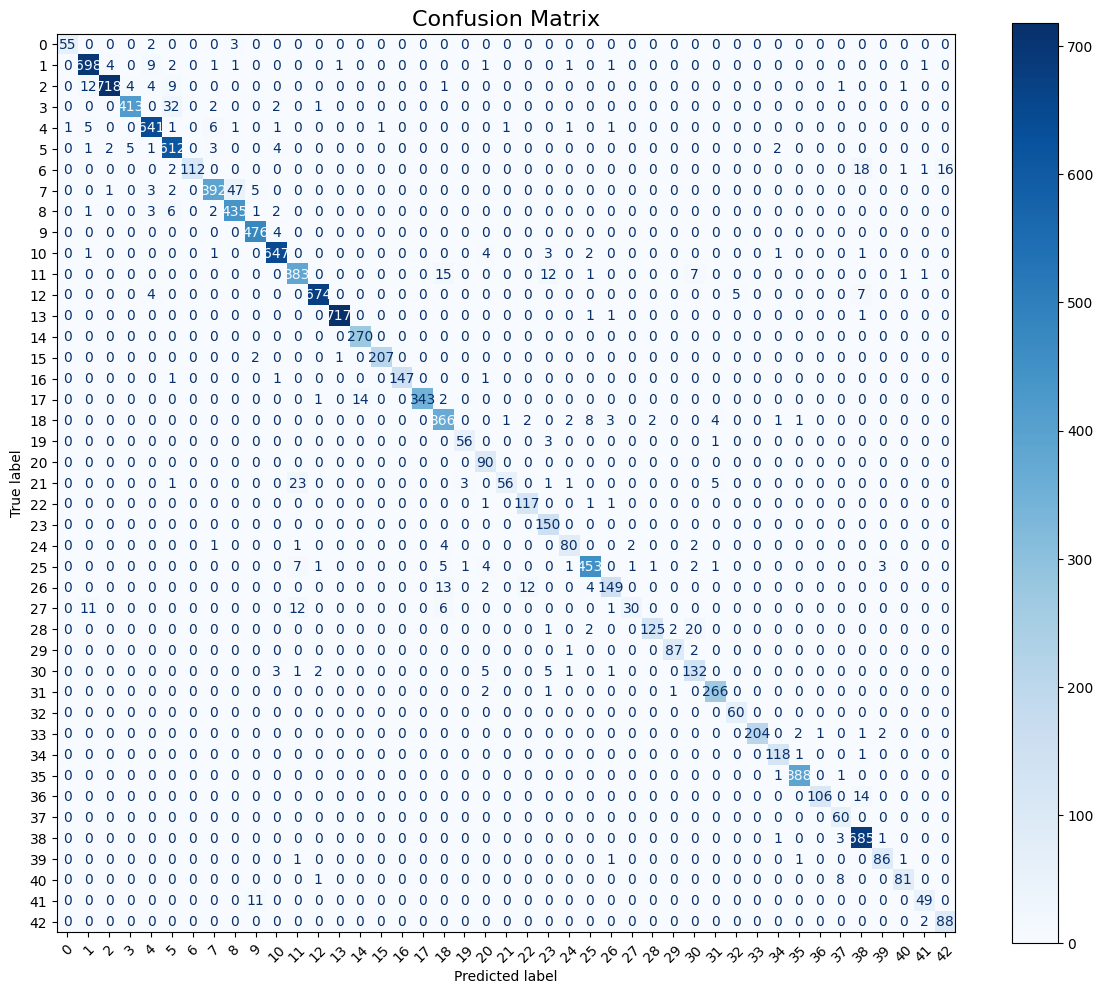

In [9]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100.0 * correct / total
    print(f"\n✅ Test Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(12, 10))  # 👈 Adjust size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
test_model(model, test_loader)
